### Importing Libraries

In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import pmdarima as pm
from fbprophet import Prophet

%matplotlib inline

### Importing Cryptocurrencies Dataset

In [2]:
dateparse = lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors = 'coerce')
Crypto = pd.read_csv('Crypto_All.csv',parse_dates=['Date'], date_parser=dateparse)
pd.set_option('display.max_columns', None)
Crypto.head(5)

,Currency_Name,Date,Price,Open,High,Low,Vol.,Change %
0,Aave,2018-01-30,0.15,0.17,0.17,0.14,530470.0,-7.95
1,Aave,2018-01-31,0.14,0.15,0.15,0.13,396050.0,-11.10
2,Aave,2018-02-01,0.11,0.14,0.14,0.11,987260.0,-17.46
3,Aave,2018-02-02,0.10,0.11,0.11,0.08,1810000.0,-8.32
4,Aave,2018-02-03,0.11,0.10,0.12,0.09,1200000.0,6.85


### Dataset Profiling

In [3]:
print('Dataset Dimension :' ,Crypto.ndim)
print('Dataset Shape :' ,Crypto.shape)
print('Dataset Size :' ,Crypto.size)

Dataset Dimension : 2
Dataset Shape : (53835, 8)
Dataset Size : 430680


In [4]:
Crypto_types = Crypto.dtypes.reset_index()
Crypto_types.columns = ['Features','Types']
Crypto_types

,Features,Types
0,Currency_Name,object
1,Date,datetime64[ns]
2,Price,float64
3,Open,float64
4,High,float64
5,Low,float64
6,Vol.,float64
7,Change %,float64


### Dataset Inspection

### Missing Value and Blank Value Check

In [5]:
miss_data = Crypto.isnull().sum().reset_index()
miss_data.columns = ['Features','Missing Values']
blank_data = Crypto.apply(lambda x: x == ' ').sum().reset_index()
blank_data.columns = ['Features','Blank Values']
merged = pd.merge(miss_data,blank_data, on=['Features'])
merged['Filling Factor'] = (Crypto.shape[0]-miss_data['Missing Values'] + Crypto.shape[0]-blank_data['Blank Values'])/Crypto.shape[0]*50
merged.sort_values(by='Filling Factor',ascending=True)

,Features,Missing Values,Blank Values,Filling Factor
0,Currency_Name,0,0,100.0
1,Date,0,0,100.0
2,Price,0,0,100.0
3,Open,0,0,100.0
4,High,0,0,100.0
5,Low,0,0,100.0
6,Vol.,0,0,100.0
7,Change %,0,0,100.0


### Choosing 2 Currency Name to be Analyzed

 - Bitcoin
 - Ethereum

### Creating New Dataframe for Each Currrency Name

### Bitcoin

In [6]:
Btc = Crypto.loc[Crypto['Currency_Name'] == 'Bitcoin']
Btc

,Currency_Name,Date,Price,Open,High,Low,Vol.,Change %
3818,Bitcoin,2010-07-18,0.1,0.0,0.1,0.1,80.0,0.00
3819,Bitcoin,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.00
3820,Bitcoin,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.00
3821,Bitcoin,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.00
3822,Bitcoin,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.00
...,...,...,...,...,...,...,...,...
7869,Bitcoin,2021-08-20,49324.0,46756.7,49343.3,46646.8,83190.0,5.49
7870,Bitcoin,2021-08-21,48875.8,49330.0,49719.1,48293.5,18200.0,-0.91
7871,Bitcoin,2021-08-22,49254.5,48870.4,49480.3,48151.0,49320.0,0.77
7872,Bitcoin,2021-08-23,49539.7,49255.4,50498.8,49038.6,75370.0,0.58


### Ethereum

In [7]:
Etr = Crypto.loc[Crypto['Currency_Name'] == 'Ethereum']
Etr

,Currency_Name,Date,Price,Open,High,Low,Vol.,Change %
22084,Ethereum,2016-03-10,11.75,11.20,11.85,11.07,0.0,4.91
22085,Ethereum,2016-03-11,11.95,11.75,11.95,11.75,180.0,1.70
22086,Ethereum,2016-03-12,12.92,11.95,13.45,11.95,830.0,8.12
22087,Ethereum,2016-03-13,15.07,12.92,15.07,12.92,1300.0,16.64
22088,Ethereum,2016-03-14,12.50,15.07,15.07,11.40,92180.0,-17.05
...,...,...,...,...,...,...,...,...
24073,Ethereum,2021-08-20,3284.21,3184.83,3300.36,3179.18,739320.0,3.12
24074,Ethereum,2021-08-21,3223.96,3285.12,3307.33,3200.19,768740.0,-1.83
24075,Ethereum,2021-08-22,3238.70,3224.17,3271.94,3128.98,747650.0,0.46
24076,Ethereum,2021-08-23,3319.49,3238.41,3375.42,3231.96,1090000.0,2.49


### Dataset Date Range

### Bitcoin

In [8]:
print("Bitcoin Minimum date value : {}".format(Btc['Date'].min()))
print("Bitcoin Maximum date value : {}".format(Btc['Date'].max()))

Bitcoin Minimum date value : 2010-07-18 00:00:00
Bitcoin Maximum date value : 2021-08-24 00:00:00


### Ethereum

In [9]:
print("Ethereum Minimum date value : {}".format(Etr['Date'].min()))
print("Ethereum Maximum date value : {}".format(Etr['Date'].max()))

Ethereum Minimum date value : 2016-03-10 00:00:00
Ethereum Maximum date value : 2021-08-24 00:00:00


### Exploratory Data

### Bitcoin

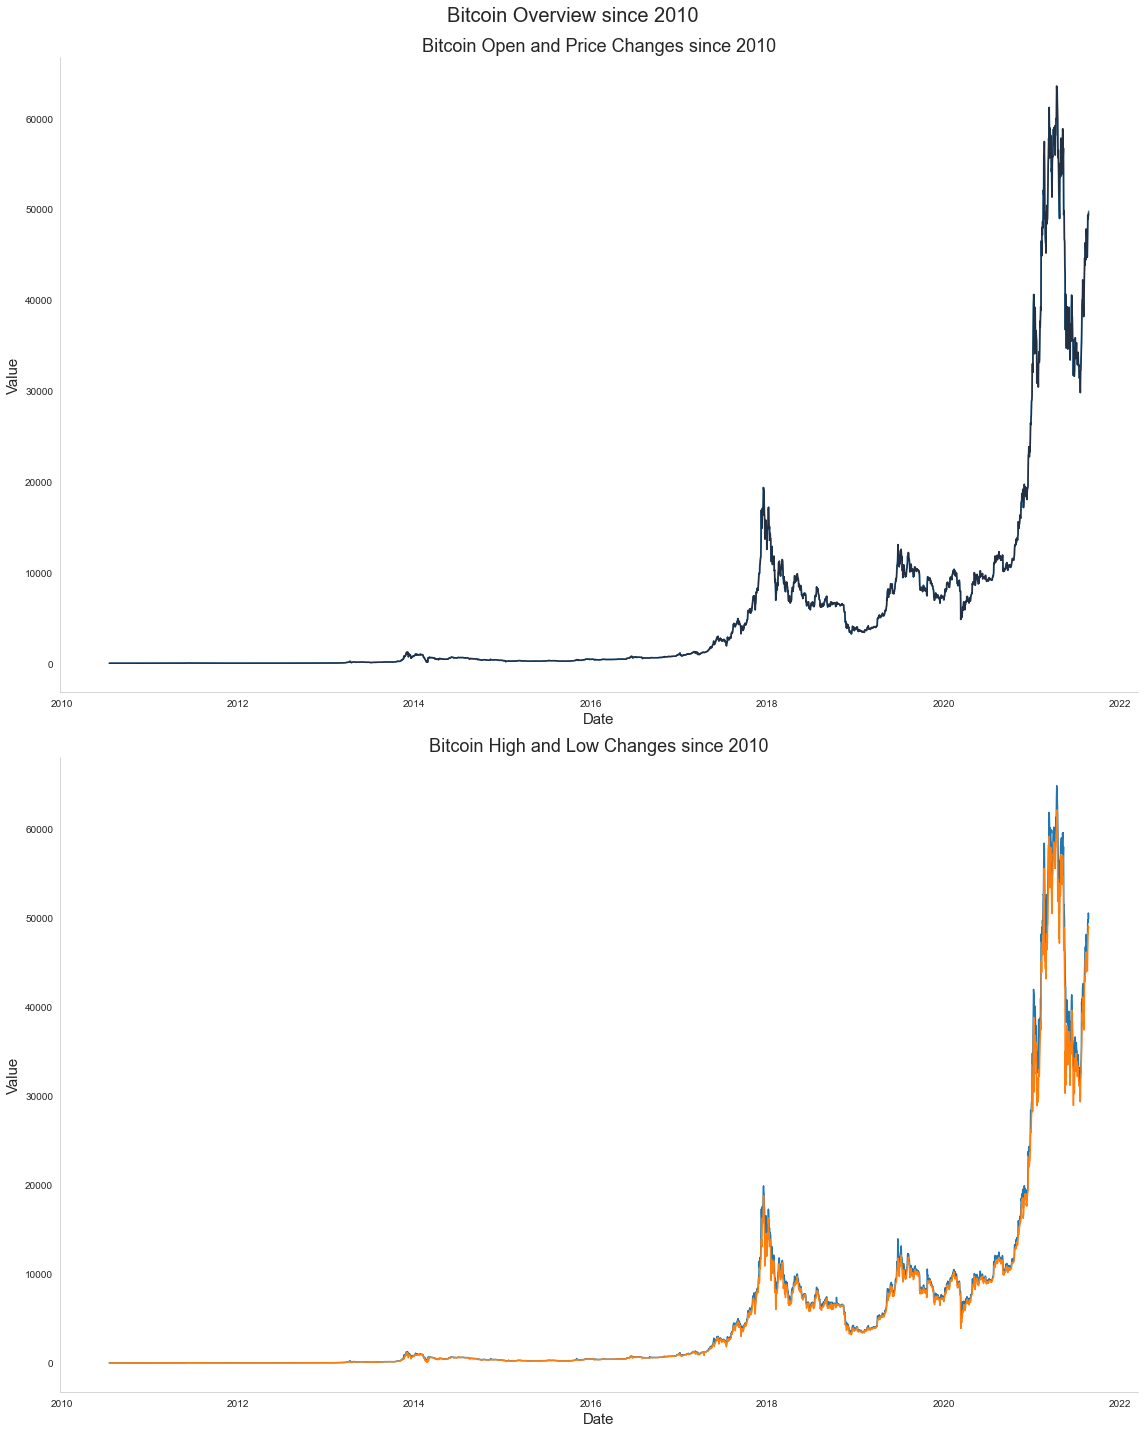

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(16,20))
fig.suptitle("Bitcoin Overview since 2010", fontsize=20, verticalalignment="bottom")
 
#Plot 1
colors1 = ['#FF9A00','#242F41']

ax1=sns.lineplot(data=Btc, x='Date',y='Price',ax=ax1)
ax1=sns.lineplot(data=Btc, x='Date',y='Open',ax=ax1, color=colors1[1])
ax1.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax1.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Bitcoin Open and Price Changes since 2010',fontsize=18, fontweight='normal')

#Plot 2
ax2=sns.lineplot(data=Btc, x='Date',y='High',ax=ax2)
ax2=sns.lineplot(data=Btc, x='Date',y='Low',ax=ax2)
ax2.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax2.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Bitcoin High and Low Changes since 2010',fontsize=18, fontweight='normal')

plt.tight_layout()

Text(0.5, 1.0, 'Bitcoin Volume Changes since 2010')

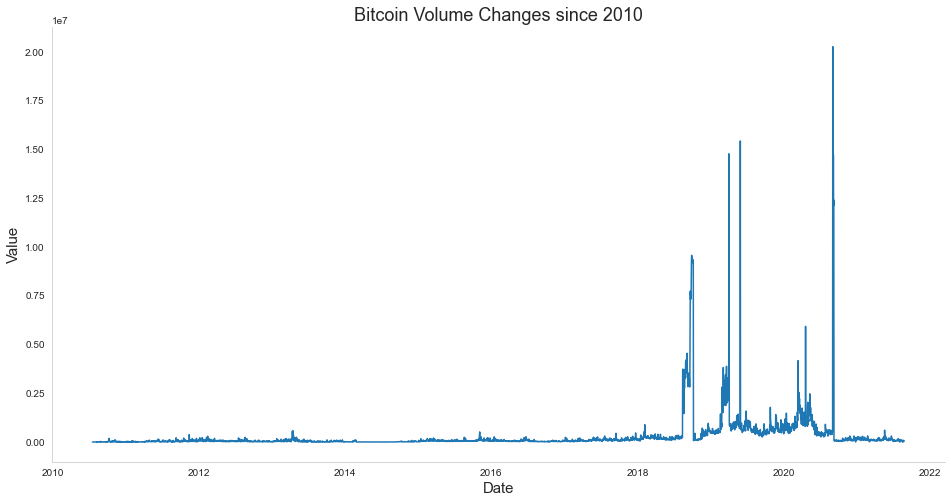

In [11]:
fig3=plt.figure(figsize=(16,8))
ax3=sns.lineplot(data=Btc, x='Date',y='Vol.')
ax3.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax3.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Bitcoin Volume Changes since 2010',fontsize=18, fontweight='normal')

### Ethereum

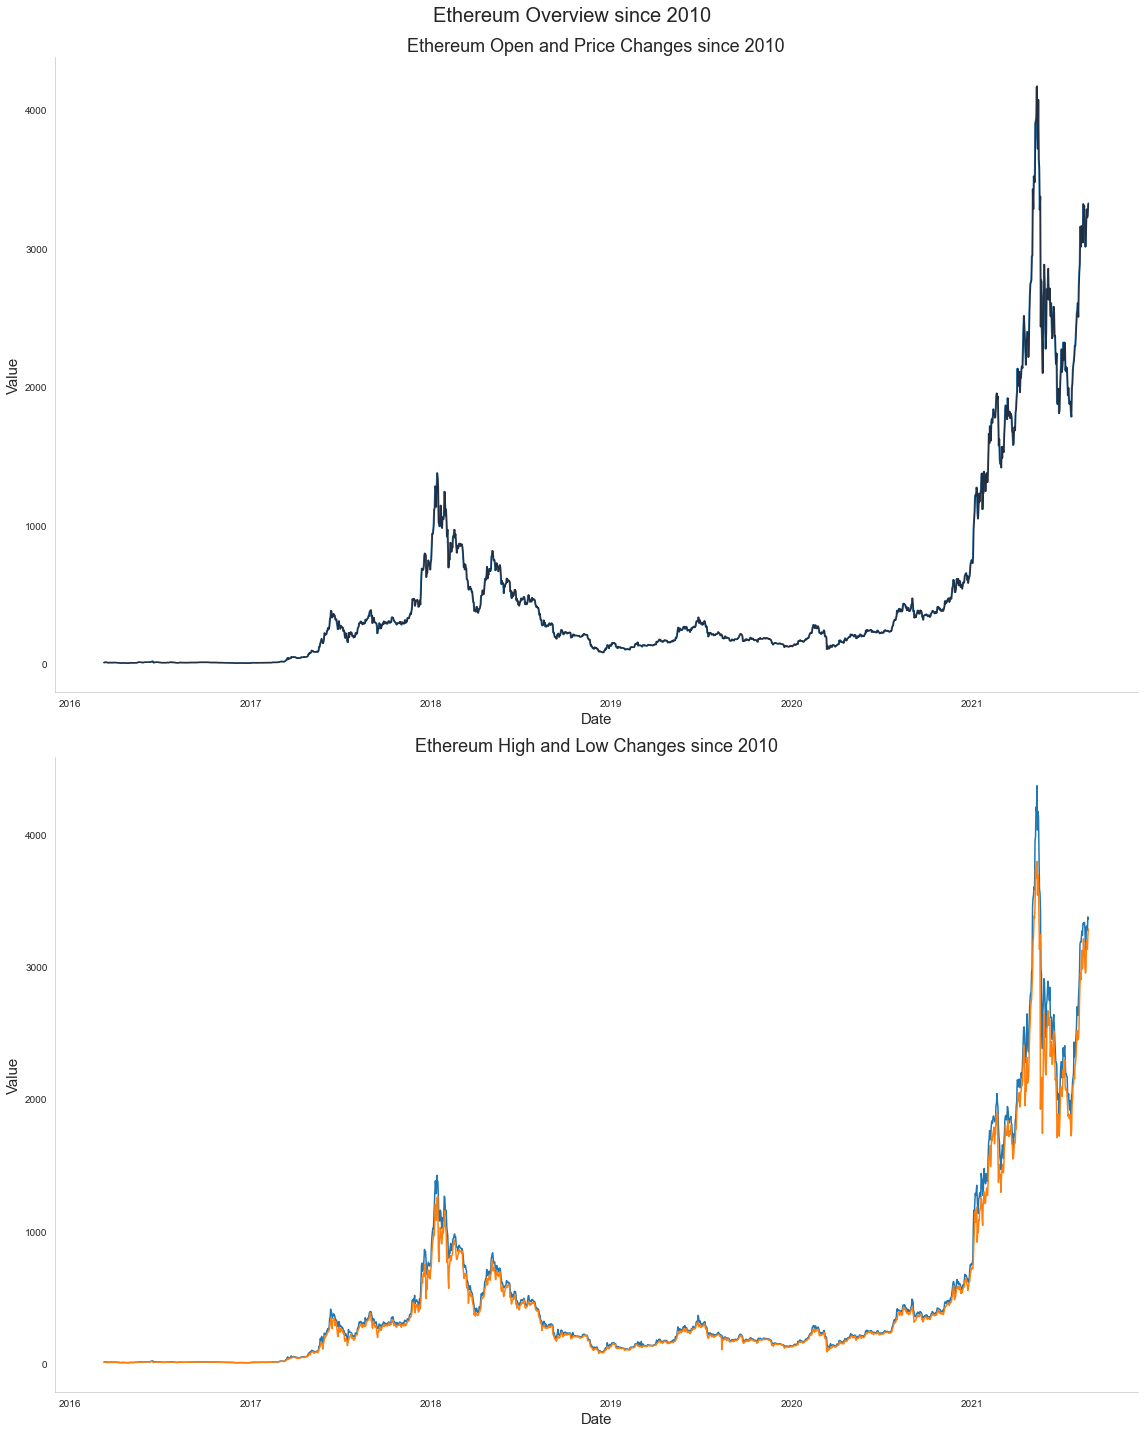

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

fig, (ax4, ax5) = plt.subplots(2, 1,figsize=(16,20))
fig.suptitle("Ethereum Overview since 2010", fontsize=20, verticalalignment="bottom")
 
#Plot 1
colors1 = ['#FF9A00','#242F41']

ax4=sns.lineplot(data=Etr, x='Date',y='Price',ax=ax4)
ax4=sns.lineplot(data=Etr, x='Date',y='Open',ax=ax4, color=colors1[1])
ax4.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax4.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.set_title('Ethereum Open and Price Changes since 2010',fontsize=18, fontweight='normal')

#Plot 2
ax5=sns.lineplot(data=Etr, x='Date',y='High',ax=ax5)
ax5=sns.lineplot(data=Etr, x='Date',y='Low',ax=ax5)
ax5.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax5.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.set_title('Ethereum High and Low Changes since 2010',fontsize=18, fontweight='normal')

plt.tight_layout()

Text(0.5, 1.0, 'Ethereum Volume Changes since 2010')

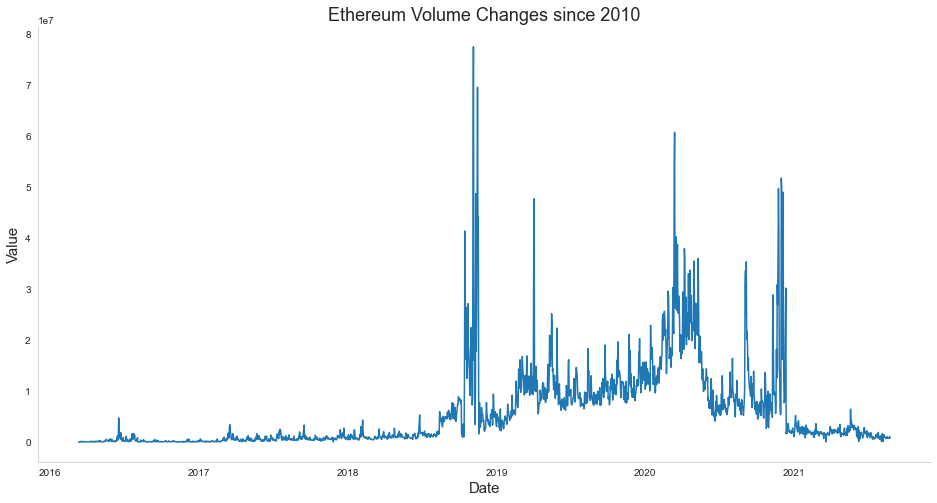

In [13]:
fig6=plt.figure(figsize=(16,8))
ax6=sns.lineplot(data=Etr, x='Date',y='Vol.')
ax6.set_ylabel('Value',fontsize=15,fontweight='normal')    
ax6.set_xlabel('Date',fontsize=15,fontweight='normal') 
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.set_title('Ethereum Volume Changes since 2010',fontsize=18, fontweight='normal')

### Time Series Stationary Checking

### Bitcoin

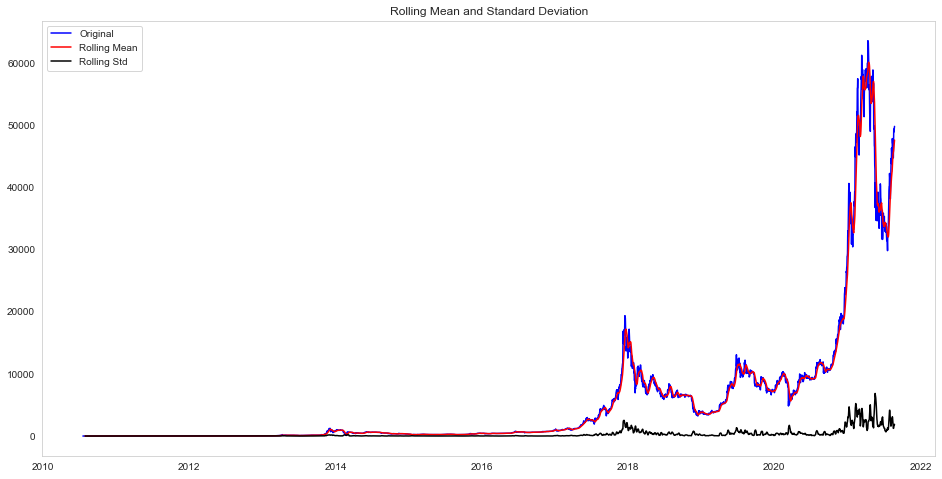

Results of dickey fuller test
Test Statistics                   0.157982
p-value                           0.969804
No. of lags used                 31.000000
Number of observations used    4024.000000
critical value (1%)              -3.431976
critical value (5%)              -2.862259
critical value (10%)             -2.567152
dtype: float64


In [14]:
# Setting Date as Index
btc_date_index = Btc.set_index('Date')

# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(btc_date_index['Price'])

### Ethereum

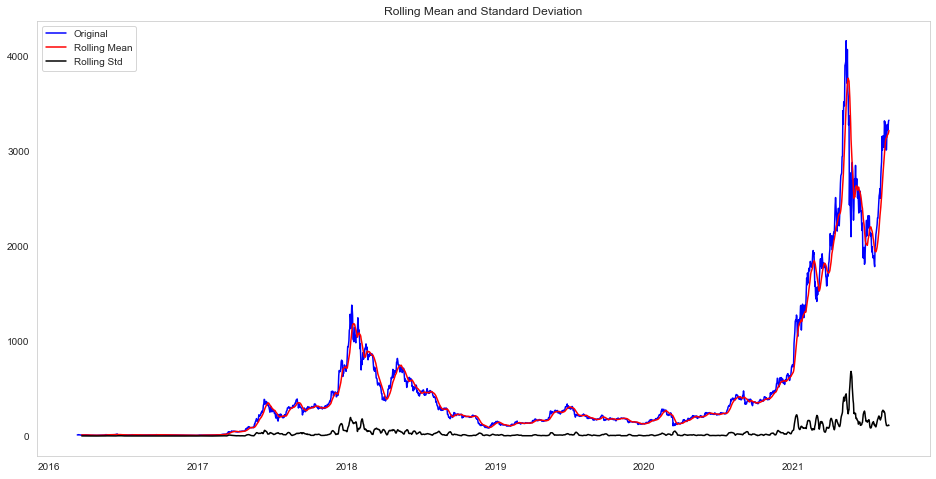

Results of dickey fuller test
Test Statistics                   1.392900
p-value                           0.997082
No. of lags used                 16.000000
Number of observations used    1977.000000
critical value (1%)              -3.433662
critical value (5%)              -2.863003
critical value (10%)             -2.567549
dtype: float64


In [15]:
# Setting Date as Index
etr_date_index = Etr.set_index('Date')

# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(etr_date_index['Price'])

### Time Series Decomposition 

### Bitcoin

### Multiplicative

<Figure size 432x288 with 0 Axes>

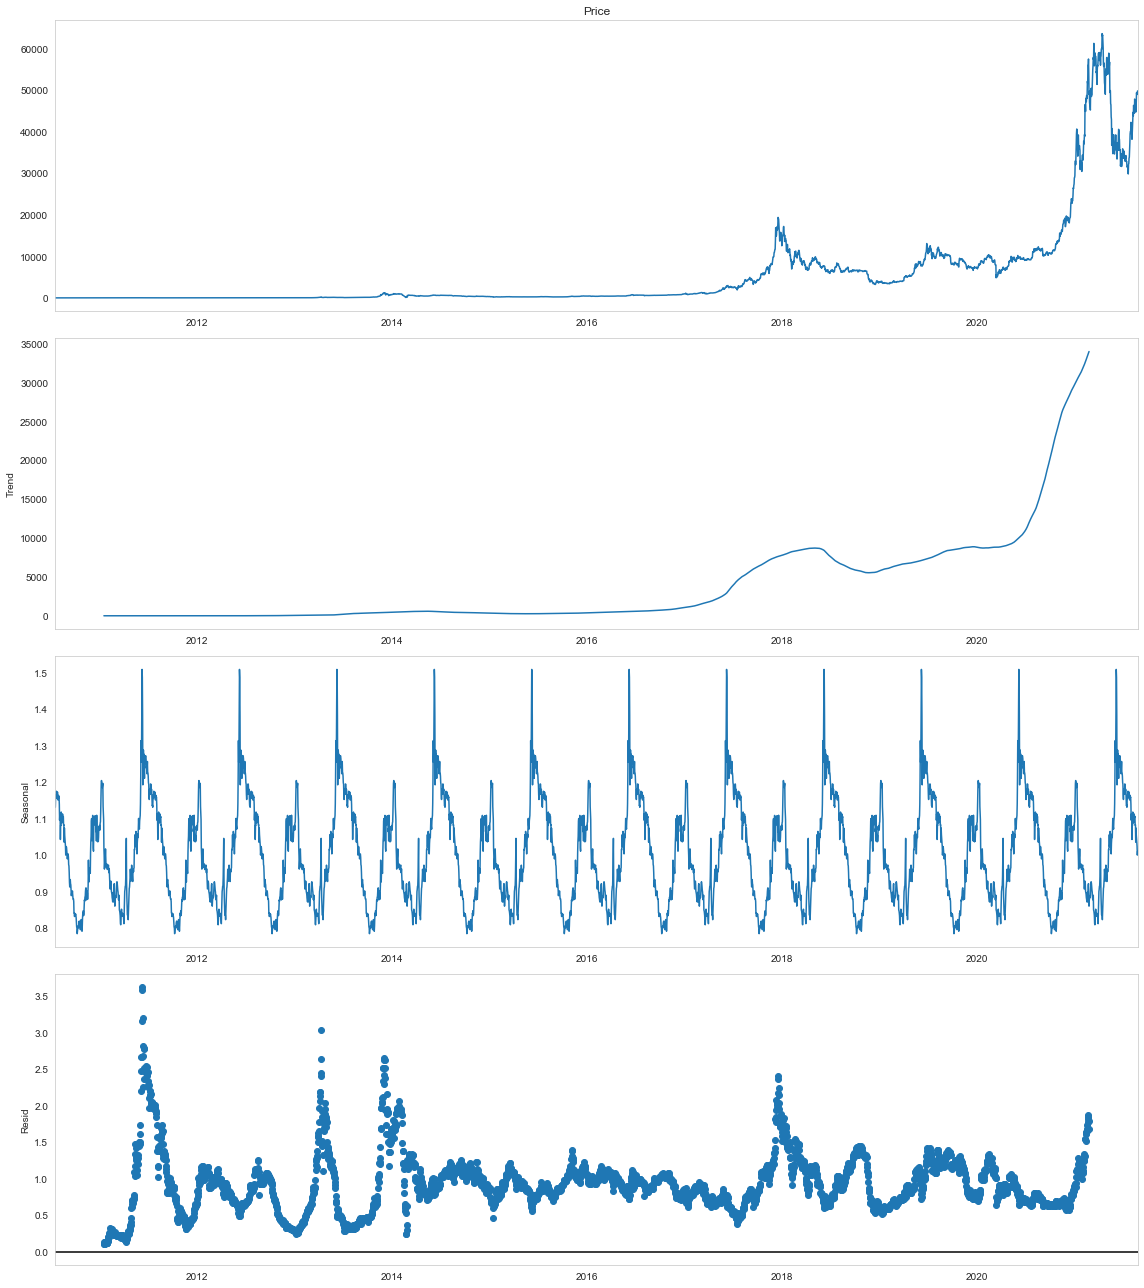

In [16]:
result1 = seasonal_decompose(btc_date_index['Price'], model='multiplicative', period = 365)
fig = plt.figure()  
fig = result1.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Additive

<Figure size 432x288 with 0 Axes>

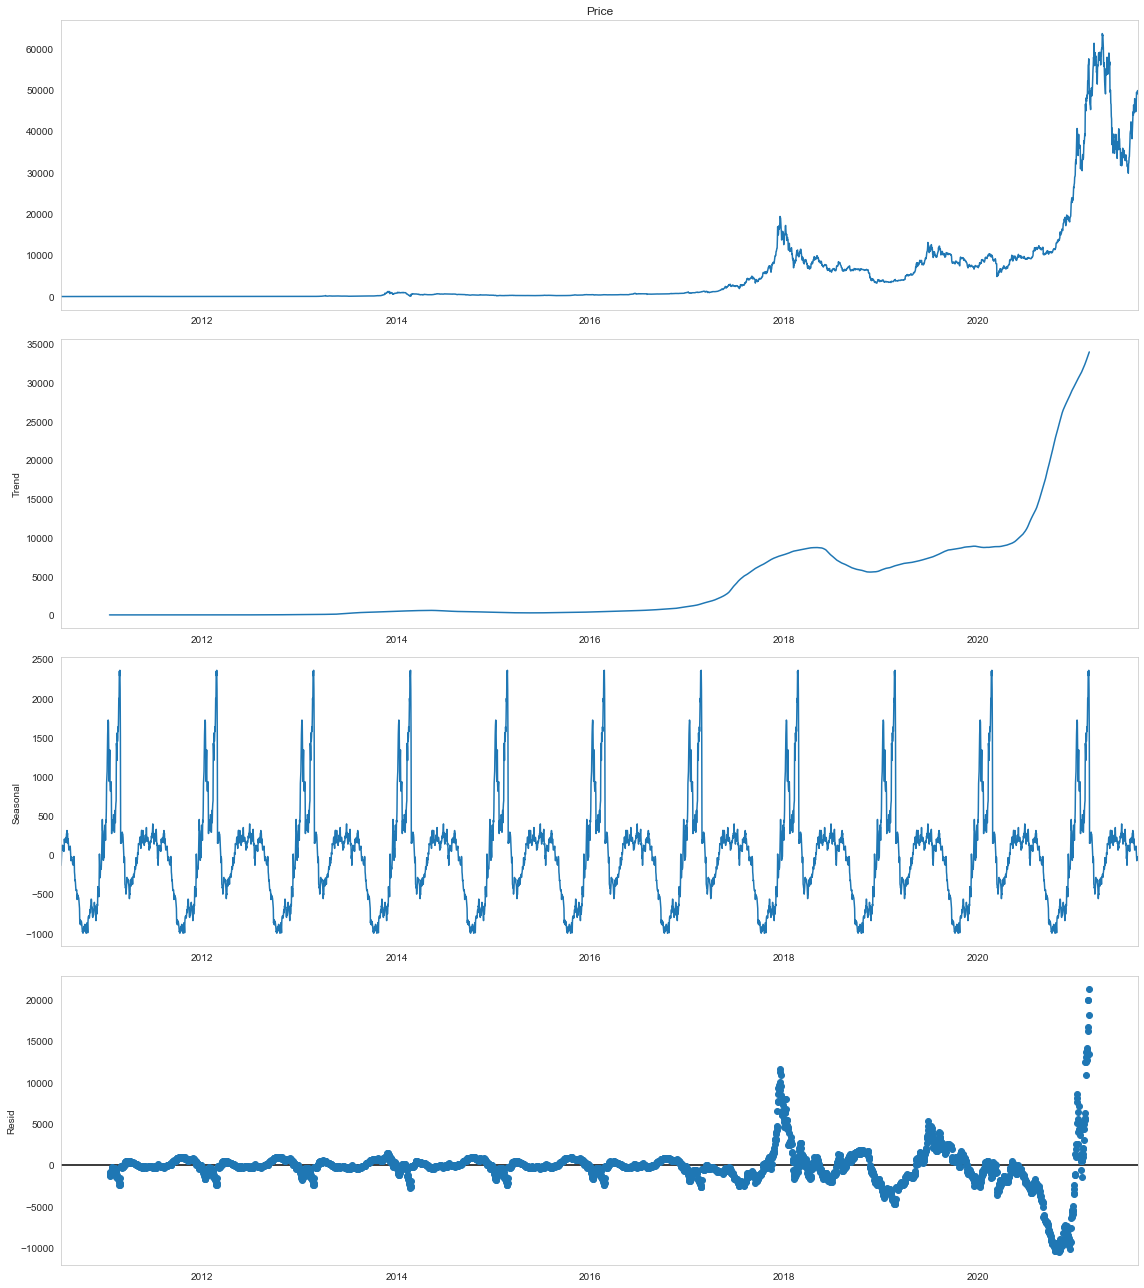

In [17]:
result2 = seasonal_decompose(btc_date_index['Price'], model='additive', period = 365)
fig = plt.figure()  
fig = result2.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Ethereum

### Multiplicative

<Figure size 432x288 with 0 Axes>

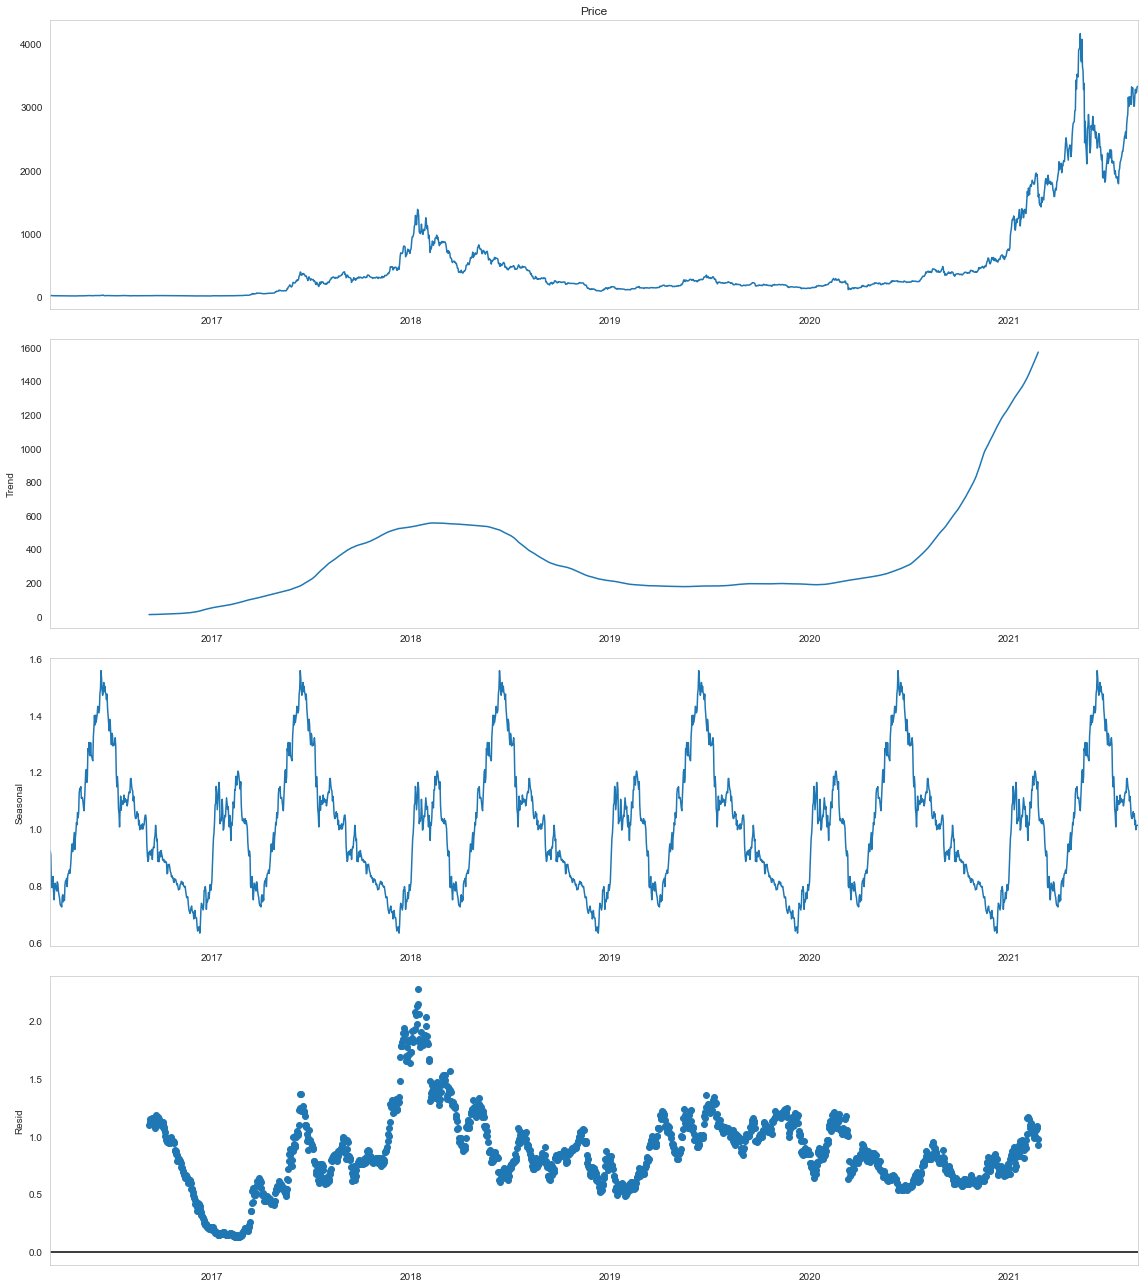

In [18]:
result3 = seasonal_decompose(etr_date_index['Price'], model='multiplicative', period = 365)
fig = plt.figure()  
fig = result3.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Additive

<Figure size 432x288 with 0 Axes>

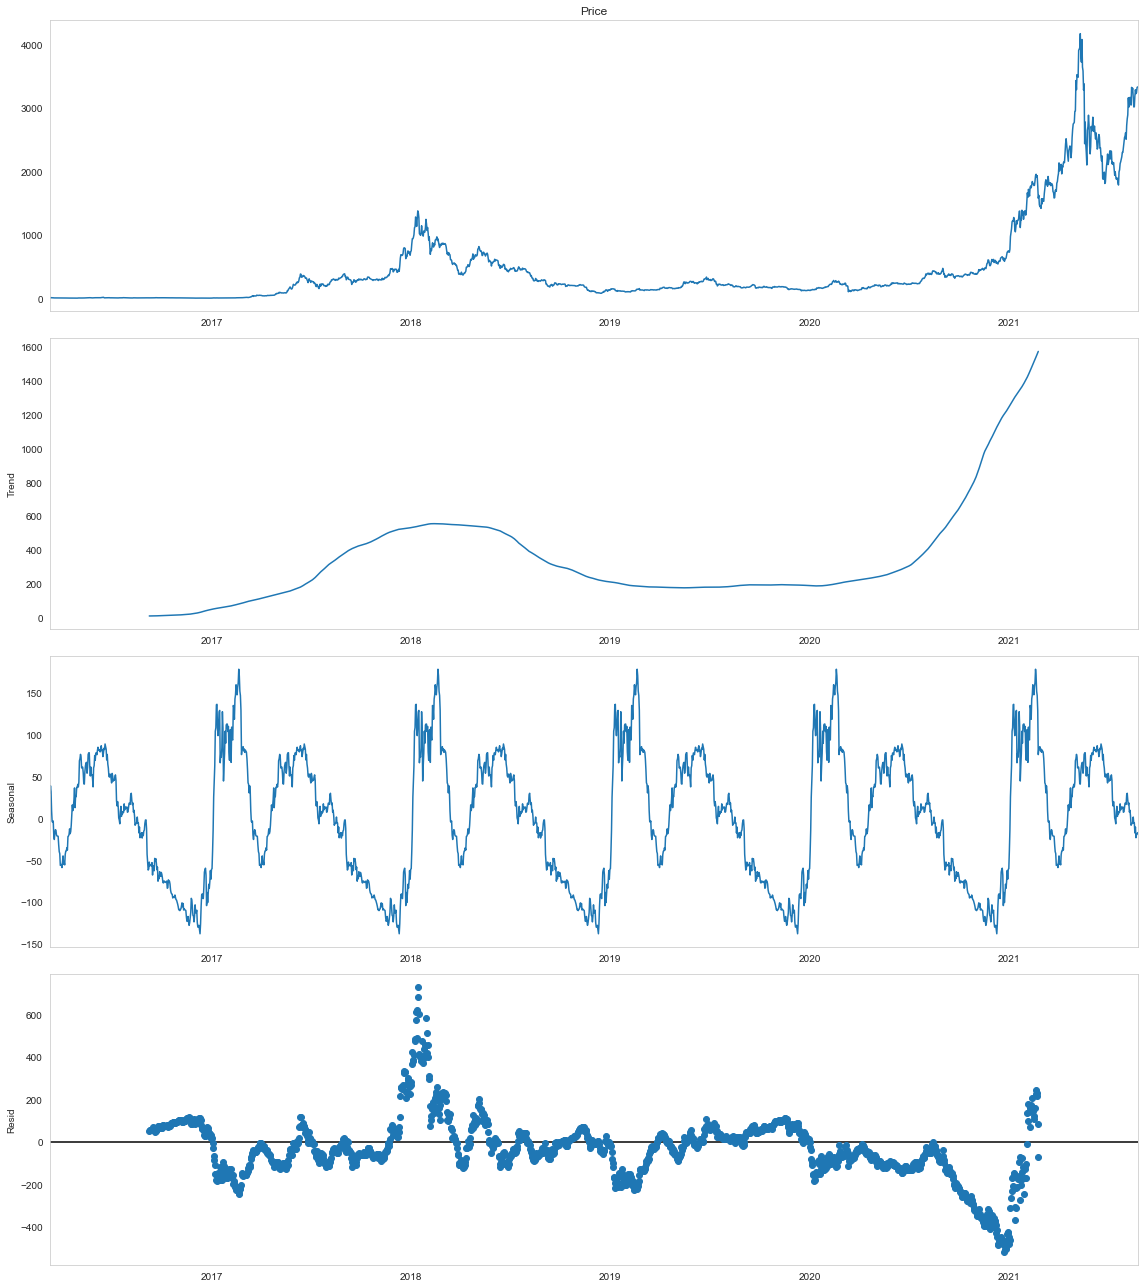

In [19]:
result4 = seasonal_decompose(etr_date_index['Price'], model='additive', period = 365)
fig = plt.figure()  
fig = result4.plot()  
fig.set_size_inches(16,18)
plt.tight_layout()

### Preparing Dataset For Forecasting Model

### Bitcoin

No handles with labels found to put in legend.


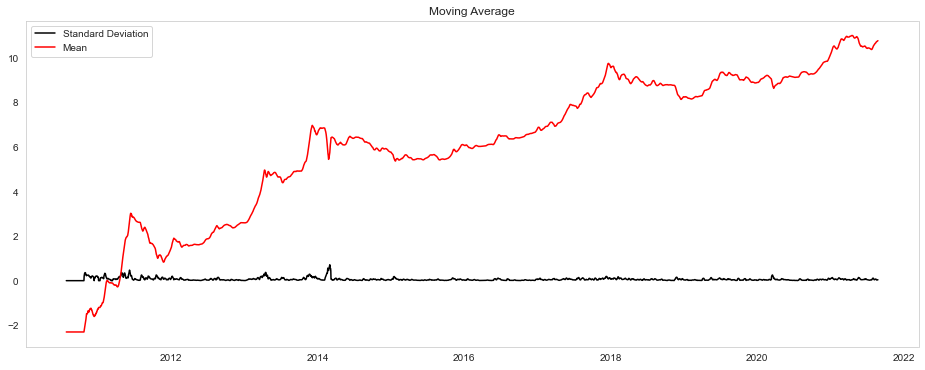

In [20]:
# If not stationary then eliminate trend
# Eliminate trend
from pylab import rcParams
btc_log = np.log(btc_date_index['Price'])
moving_avg = btc_log.rolling(12).mean()
std_dev = btc_log.rolling(12).std()

plt.figure(figsize=(16,6))
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

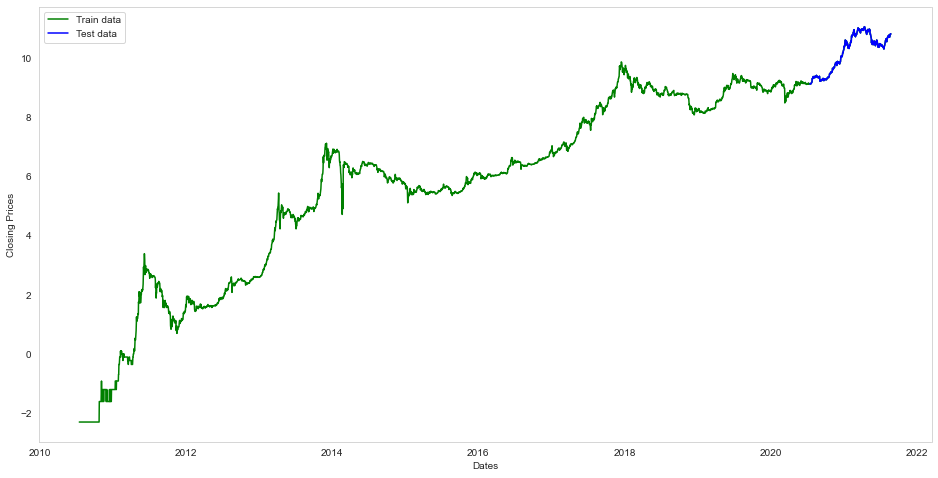

In [21]:
# Split data into Train and Training set
train_data1, test_data1 = btc_log[5:int(len(btc_log)*0.9)], btc_log[int(len(btc_log)*0.9):]
plt.figure(figsize=(16,8))
###plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(btc_log, 'green', label='Train data')
plt.plot(test_data1, 'blue', label='Test data')
plt.legend()

### Ethereum

No handles with labels found to put in legend.


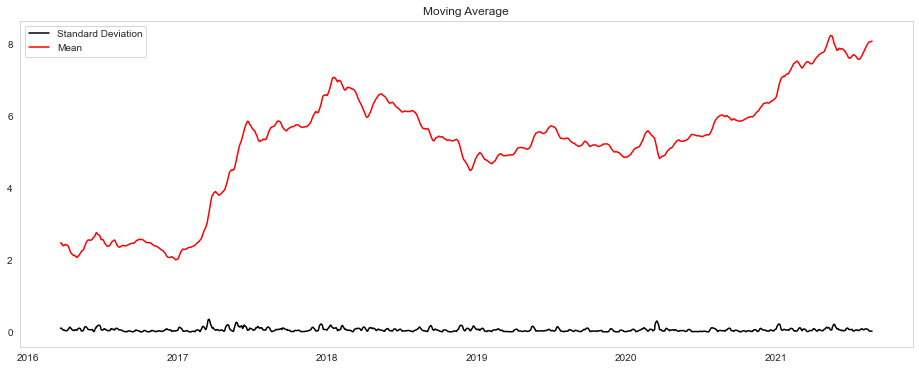

In [22]:
# If not stationary then eliminate trend
# Eliminate trend
from pylab import rcParams
etr_log = np.log(etr_date_index['Price'])
moving_avg2 = etr_log.rolling(12).mean()
std_dev2 = etr_log.rolling(12).std()

plt.figure(figsize=(16,6))
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev2, color ="black", label = "Standard Deviation")
plt.plot(moving_avg2, color="red", label = "Mean")
plt.legend()
plt.show()

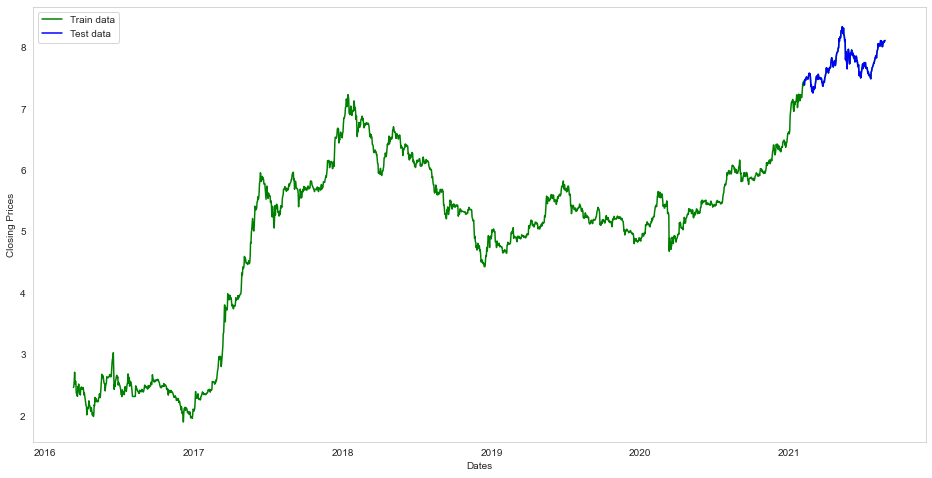

In [23]:
# Split data into Train and Training set
train_data2, test_data2 = etr_log[5:int(len(etr_log)*0.9)], etr_log[int(len(etr_log)*0.9):]
plt.figure(figsize=(16,8))
###plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(etr_log, 'green', label='Train data')
plt.plot(test_data2, 'blue', label='Test data')
plt.legend()

### AUTO ARIMA Model

### Bitcoin

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=14.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-905.091, Time=0.69 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-8863.349, Time=4.82 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-4433.477, Time=4.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-779.026, Time=0.90 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-7769.723, Time=0.44 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-9243.132, Time=11.62 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=26.18 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=19.28 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-950.725, Time=3.60 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-9241.447, Time=17.76 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-9241.611, Time=18.52 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-4444.441, Time=8.07 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-9248.510, Time=29.84 sec
 ARIMA(2,0,1)(1,1,0

C:\Users\GIGABYTE\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


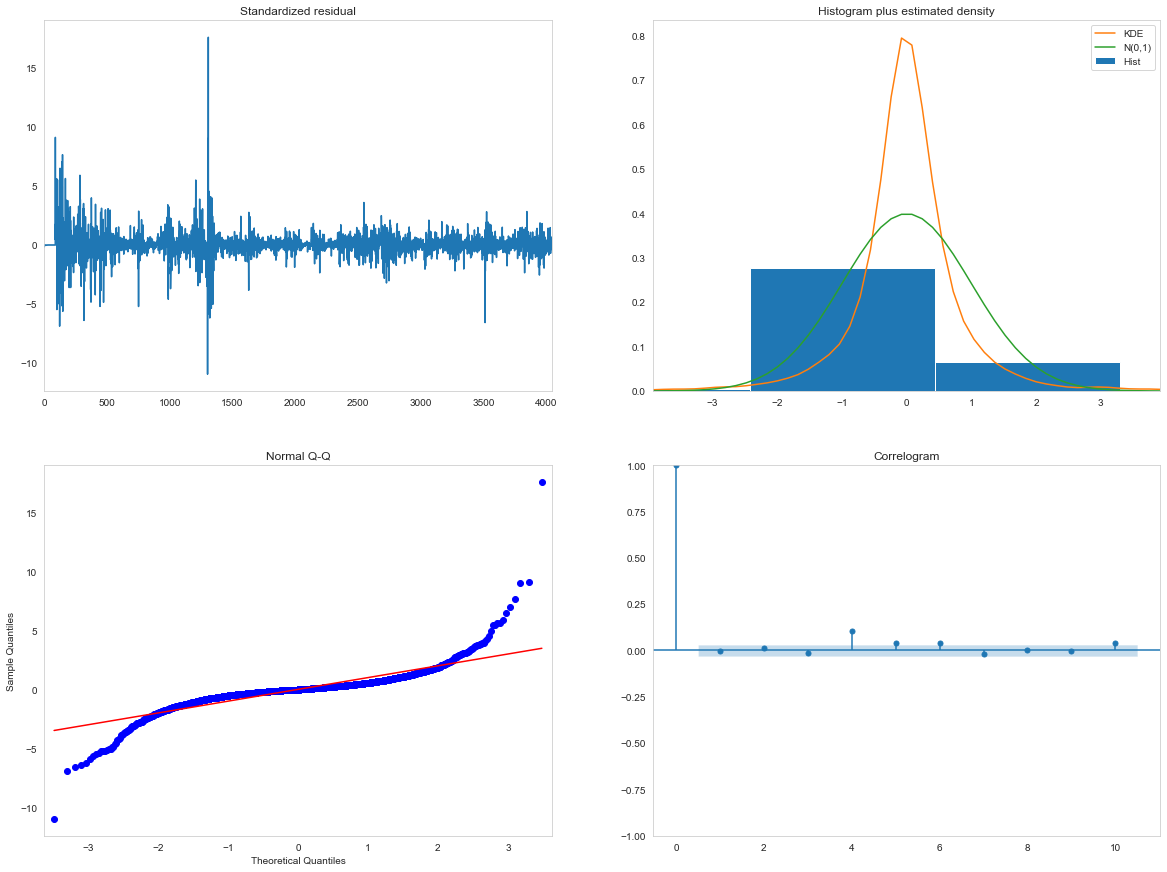

In [32]:
smodel1 = pm.auto_arima(btc_log, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


print(smodel1.summary())
smodel1.plot_diagnostics(figsize=(20,15))
plt.show()

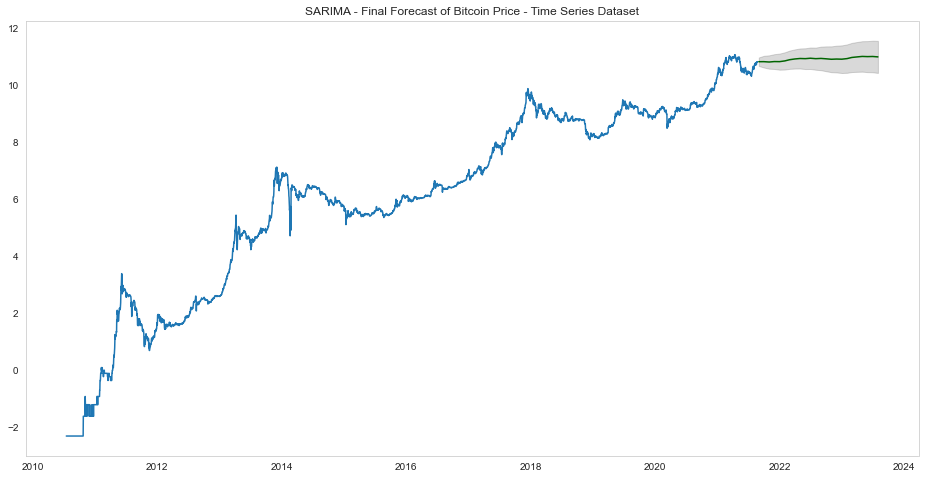

In [34]:
# Forecast
n_periods = 24
fitted, confint = smodel1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(btc_log.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16,8))
plt.plot(btc_log)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Bitcoin Price - Time Series Dataset")
plt.show()

### Ethereum

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.91 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-540.846, Time=0.41 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-4893.151, Time=2.56 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-2262.614, Time=3.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-492.308, Time=0.23 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-4367.689, Time=0.70 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-5088.464, Time=8.24 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=10.34 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.76 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-587.660, Time=1.98 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-5090.297, Time=10.82 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-4893.940, Time=4.30 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=11.69 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.66 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept 

C:\Users\GIGABYTE\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


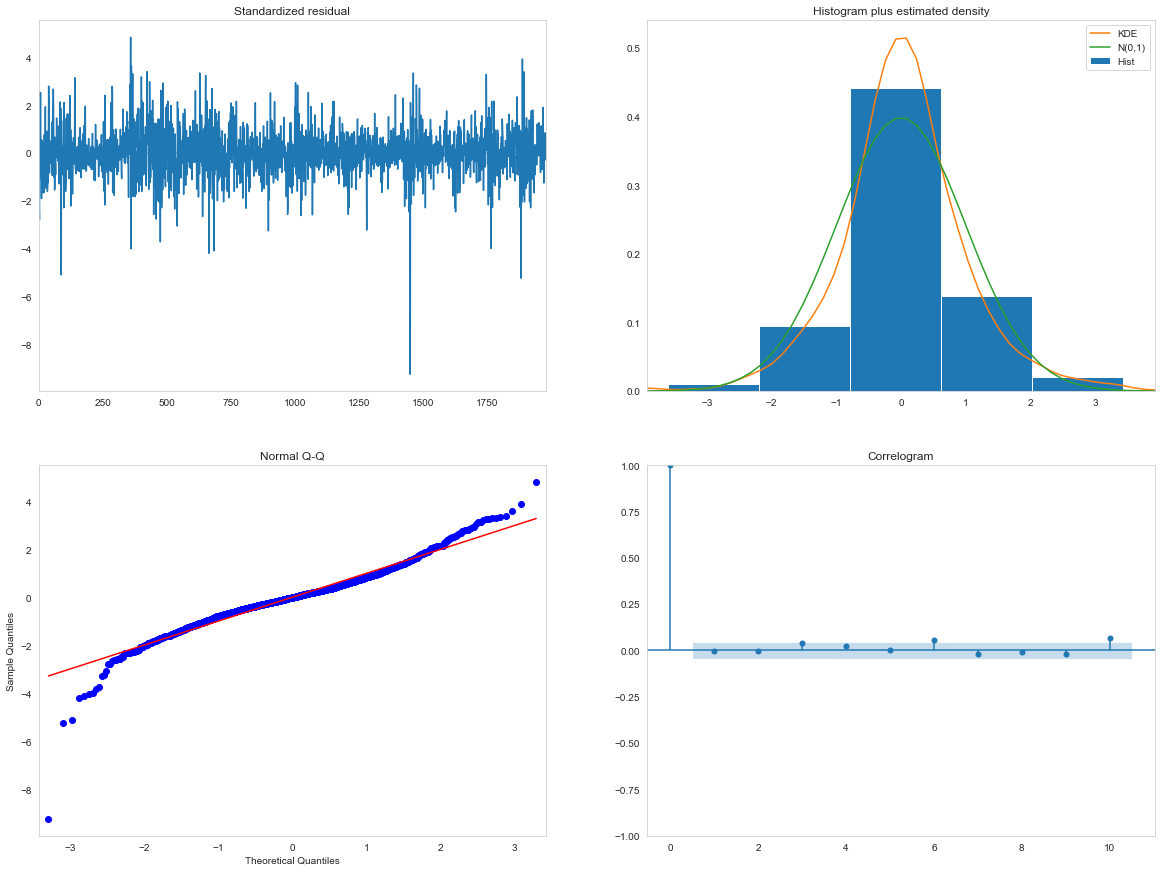

In [33]:
smodel2 = pm.auto_arima(etr_log, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


print(smodel2.summary())
smodel2.plot_diagnostics(figsize=(20,15))
plt.show()

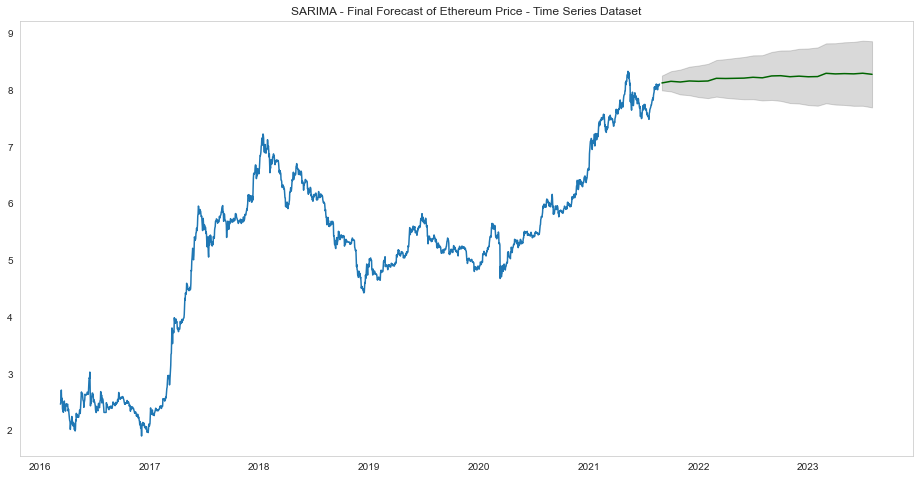

In [35]:
# Forecast
n_periods = 24
fitted2, confint = smodel2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc2 = pd.date_range(etr_log.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series2 = pd.Series(fitted2, index=index_of_fc2)
lower_series2 = pd.Series(confint[:, 0], index=index_of_fc2)
upper_series2 = pd.Series(confint[:, 1], index=index_of_fc2)

# Plot
plt.figure(figsize=(16,8))
plt.plot(etr_log)
plt.plot(fitted_series2, color='darkgreen')
plt.fill_between(lower_series2.index, 
                 lower_series2, 
                 upper_series2, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Ethereum Price - Time Series Dataset")
plt.show()

### FBProphet Model

### Selecting and Renaming Dataset To Fit FBProphet Model

In [24]:
# Bitcoin
btc_p = Btc[['Date','Price']]
btc_p.columns=['ds','y']

# Ethereum
etr_p = Etr[['Date','Price']]
etr_p.columns=['ds','y']

# set the uncertainty interval to 95% (the Prophet default is 80%)
prophet = Prophet(interval_width=0.95)

### Fitting FBProphet Model To Dataset

### Bitcoin

In [ ]:
prophet.fit(btc_p)

### Making Future Data For Forecasting

### Bitcoin

In [ ]:
future_btc_dates = prophet.make_future_dataframe(periods=36, freq='MS')
future_btc_dates.tail()

### FBProphet Forecasting 

### Bitcoin

In [ ]:
forecast = prophet.predict(future_btc_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
prophet.plot(forecast, uncertainty=True)

In [ ]:
prophet.plot_components(forecast)

### Fitting FBProphet Model To Dataset

### Ethereum

In [25]:
prophet.fit(etr_p)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Making Future Data For Forecasting

### Ethereum

In [26]:
future_etr_dates = prophet.make_future_dataframe(periods=36, freq='MS')
future_etr_dates.tail()

,ds
2025,2024-04-01
2026,2024-05-01
2027,2024-06-01
2028,2024-07-01
2029,2024-08-01


### FBProphet Forecasting 

### Ethereum

In [27]:
forecast = prophet.predict(future_etr_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-03-10,-93.078303,-461.992283,292.116298
1,2016-03-11,-94.817446,-453.306395,273.524627
2,2016-03-12,-94.601577,-460.464414,277.100834
3,2016-03-13,-93.907710,-451.797046,292.295234
4,2016-03-14,-92.009039,-452.600411,254.196512


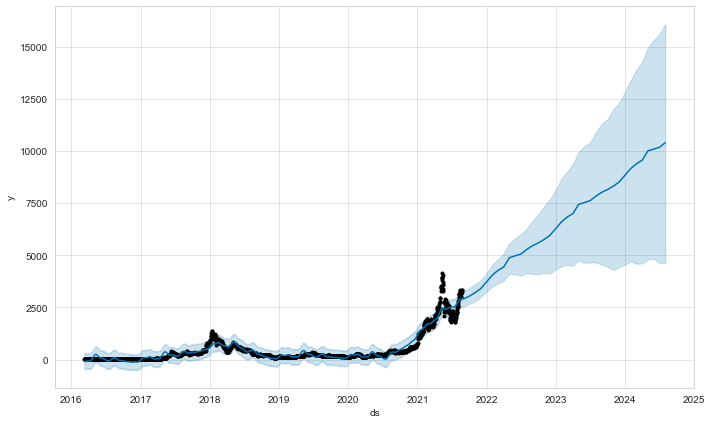

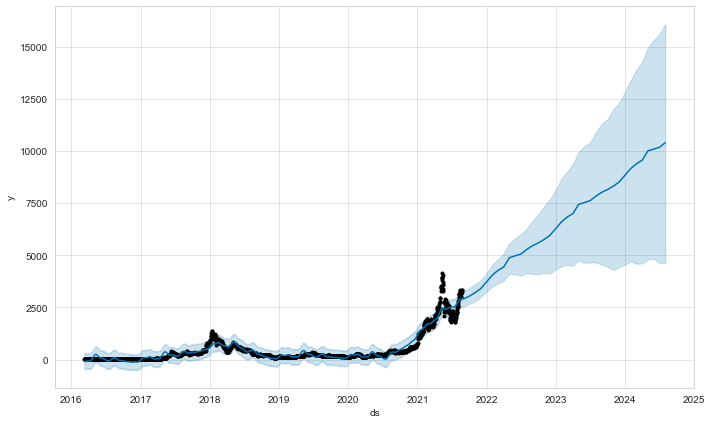

In [28]:
prophet.plot(forecast, uncertainty=True)

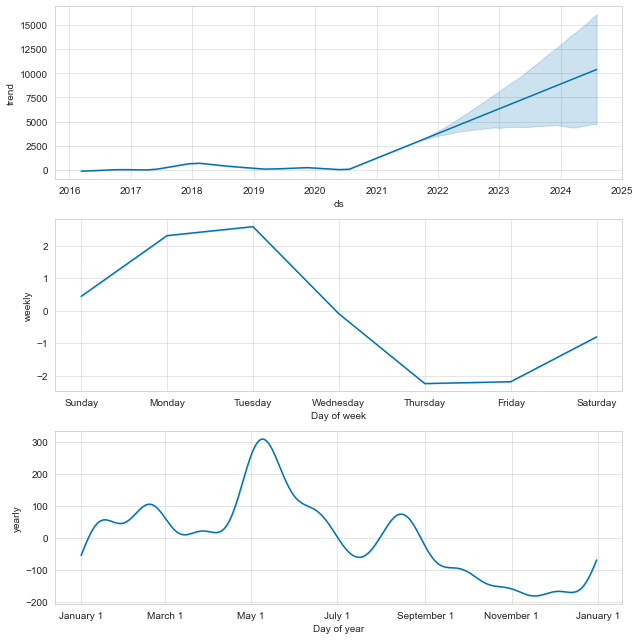

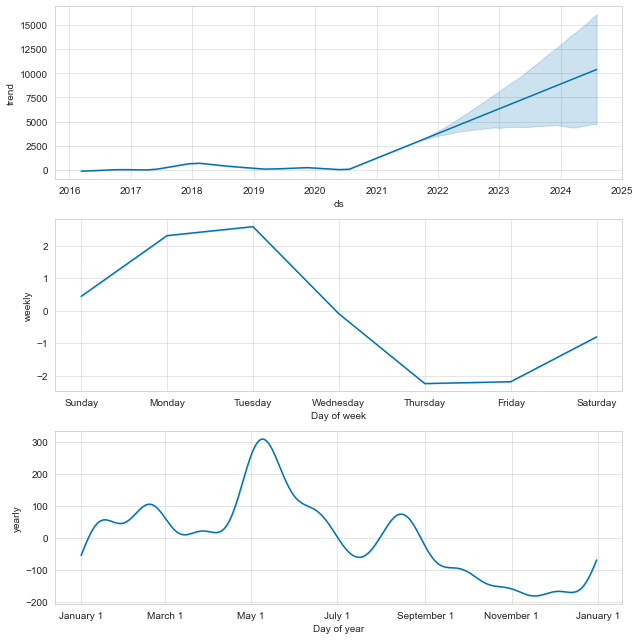

In [29]:
prophet.plot_components(forecast)